In [ ]:
# This is the notebook for implementing and testing the Kalman filter. Adding
# this file in the example section. This is for the draft pr.

In [1]:
from darts.models.filtering.kalman_filter import KalmanFilter
from matplotlib import pyplot as plt
from scipy.signal import welch

from movement import sample_data
from movement.filtering import median_filter

/home/angkul/anaconda3/envs/movement-dev2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
SHA256 hash of downloaded file: 40a6d79722dcaf7cee39627959e46a1bc10a6e1405842a7c2993d6d69b4c8195
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


In [6]:
import pandas as pd
import xarray as xr
from darts.timeseries import TimeSeries

from movement.filtering import interpolate_over_time

In [3]:
ds_wasp = sample_data.fetch_dataset("DLC_single-wasp.predictions.h5")
print(ds_wasp)

<xarray.Dataset> Size: 61kB
Dimensions:      (time: 1085, space: 2, keypoints: 2, individuals: 1)
Coordinates:
  * time         (time) float64 9kB 0.0 0.025 0.05 0.075 ... 27.05 27.07 27.1
  * space        (space) <U1 8B 'x' 'y'
  * keypoints    (keypoints) <U7 56B 'head' 'stinger'
  * individuals  (individuals) <U12 48B 'individual_0'
Data variables:
    position     (time, space, keypoints, individuals) float64 35kB 1.086e+03...
    confidence   (time, keypoints, individuals) float64 17kB 0.05305 ... 0.0
Attributes:
    fps:              40.0
    time_unit:        seconds
    source_software:  DeepLabCut
    source_file:      /home/angkul/.movement/data/poses/DLC_single-wasp.predi...
    ds_type:          poses
    frame_path:       /home/angkul/.movement/data/frames/single-wasp_frame-10...
    video_path:       None


In [4]:
# apply the filter
window = int(0.1 * ds_wasp.fps)
ds_wasp_smooth = ds_wasp.copy()
print(
    ds_wasp_smooth.update(
        {"position": median_filter(ds_wasp.position, window)}
    )
)


Missing points (marked as NaN) in input
	Individual: individual_0
		head: 0/1085 (0.0%)
		stinger: 0/1085 (0.0%)

Missing points (marked as NaN) in output
	Individual: individual_0
		head: 0/1085 (0.0%)
		stinger: 0/1085 (0.0%)
<xarray.Dataset> Size: 61kB
Dimensions:      (time: 1085, space: 2, keypoints: 2, individuals: 1)
Coordinates:
  * time         (time) float64 9kB 0.0 0.025 0.05 0.075 ... 27.05 27.07 27.1
  * space        (space) <U1 8B 'x' 'y'
  * keypoints    (keypoints) <U7 56B 'head' 'stinger'
  * individuals  (individuals) <U12 48B 'individual_0'
Data variables:
    position     (time, space, keypoints, individuals) float64 35kB 1.086e+03...
    confidence   (time, keypoints, individuals) float64 17kB 0.05305 ... 0.0
Attributes:
    fps:              40.0
    time_unit:        seconds
    source_software:  DeepLabCut
    source_file:      /home/angkul/.movement/data/poses/DLC_single-wasp.predi...
    ds_type:          poses
    frame_path:       /home/angkul/.movement/dat

In [7]:
wasp_pos = ds_wasp.position

In [8]:
wasp_pos_reshape = wasp_pos.stack(component=("space", "keypoints"))
wasp_pos_reshape = wasp_pos_reshape.rename({"individuals": "sample"})
wasp_pos_reshape = wasp_pos_reshape.transpose("time", "component", "sample")
time_index = pd.to_datetime(
    wasp_pos_reshape.time.values, unit="s"
)  # Convert to datetime
wasp_pos_reshape = wasp_pos_reshape.assign_coords(time=time_index)

ds_wasp_t = TimeSeries(wasp_pos_reshape)

In [9]:
kf = KalmanFilter(2)

In [10]:
kf.fit(ds_wasp_t)
filtered = kf.filter(ds_wasp_t)

In [11]:
print(filtered)

<TimeSeries (DataArray) (time: 1085, component: 4, sample: 1)> Size: 35kB
array([[[ 5.13555819e+002],
        [ 5.06506877e+002],
        [ 1.81142044e+001],
        [ 2.44243831e+001]],

       [[ 1.02417210e+003],
        [ 1.01087172e+003],
        [ 3.47667349e+002],
        [ 3.55647517e+002]],

       [[ 1.09943567e+003],
        [ 1.08527071e+003],
        [ 4.19643843e+002],
        [ 4.27524334e+002]],

       ...,

       [[-4.78052668e-106],
        [-4.73642779e-106],
        [-9.02233349e-106],
        [-8.95023008e-106]],

       [[-3.00567566e-121],
        [-2.96541748e-121],
        [-5.16244510e-122],
        [-5.47113469e-122]],

       [[-1.11350668e-136],
        [-1.10312790e-136],
        [-2.05749521e-136],
        [-2.04135127e-136]]])
Coordinates:
  * sample     (sample) <U12 48B 'individual_0'
  * component  (component) object 32B MultiIndex
  * space      (component) <U1 16B 'x' 'x' 'y' 'y'
  * keypoints  (component) <U7 112B 'head' 'stinger' 'head' 'stinger

In [12]:
filtered_up = filtered.values()
filtered_reshaped = filtered_up.reshape(1085, 2, 2, 1)

In [13]:
filtered_xr = xr.DataArray(
    filtered_reshaped,
    dims=[
        "time",
        "space",
        "keypoints",
        "individuals",
    ],  # Restore original names
    coords={
        "time": ds_wasp_smooth.time,  # Keep original time
        "space": ds_wasp_smooth.space,  # ('x', 'y')
        "keypoints": ds_wasp_smooth.keypoints,  # ('head', 'stinger')
        "individuals": ds_wasp_smooth.individuals,  # ('individual_0')
    },
)

In [14]:
ds_wasp_kalman = ds_wasp.copy()

In [15]:
ds_wasp_kalman["position"] = filtered_xr

# Verify the format
print(ds_wasp_kalman)

<xarray.Dataset> Size: 61kB
Dimensions:      (time: 1085, space: 2, keypoints: 2, individuals: 1)
Coordinates:
  * time         (time) float64 9kB 0.0 0.025 0.05 0.075 ... 27.05 27.07 27.1
  * space        (space) <U1 8B 'x' 'y'
  * keypoints    (keypoints) <U7 56B 'head' 'stinger'
  * individuals  (individuals) <U12 48B 'individual_0'
Data variables:
    position     (time, space, keypoints, individuals) float64 35kB 513.6 ......
    confidence   (time, keypoints, individuals) float64 17kB 0.05305 ... 0.0
Attributes:
    fps:              40.0
    time_unit:        seconds
    source_software:  DeepLabCut
    source_file:      /home/angkul/.movement/data/poses/DLC_single-wasp.predi...
    ds_type:          poses
    frame_path:       /home/angkul/.movement/data/frames/single-wasp_frame-10...
    video_path:       None


In [16]:
def plot_raw_and_smooth_timeseries_and_psd(
    ds_raw,
    ds_smooth,
    individual="individual_0",
    keypoint="stinger",
    space="x",
    time_range=None,
):
    # If no time range is specified, plot the entire time series
    if time_range is None:
        time_range = slice(0, ds_raw.time[-1])

    selection = {
        "time": time_range,
        "individuals": individual,
        "keypoints": keypoint,
        "space": space,
    }

    fig, ax = plt.subplots(2, 1, figsize=(10, 6))

    for ds, color, label in zip(
        [ds_raw, ds_smooth], ["k", "r"], ["raw", "smooth"], strict=False
    ):
        # plot position time series
        pos = ds.position.sel(**selection)
        ax[0].plot(
            pos.time,
            pos,
            color=color,
            lw=2,
            alpha=0.7,
            label=f"{label} {space}",
        )

        # interpolate data to remove NaNs in the PSD calculation
        pos_interp = interpolate_over_time(
            pos, print_report=False, fill_value="extrapolate"
        )

        # compute and plot the PSD
        freq, psd = welch(pos_interp, fs=ds.fps, nperseg=256)
        ax[1].semilogy(
            freq,
            psd,
            color=color,
            lw=2,
            alpha=0.7,
            label=f"{label} {space}",
        )

    ax[0].set_ylabel(f"{space} position (px)")
    ax[0].set_xlabel("Time (s)")
    ax[0].set_title("Time Domain")
    ax[0].legend()

    ax[1].set_ylabel("PSD (px$^2$/Hz)")
    ax[1].set_xlabel("Frequency (Hz)")
    ax[1].set_title("Frequency Domain")
    ax[1].legend()

    plt.tight_layout()
    fig.show()

/tmp/ipykernel_23299/2198635885.py:63: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


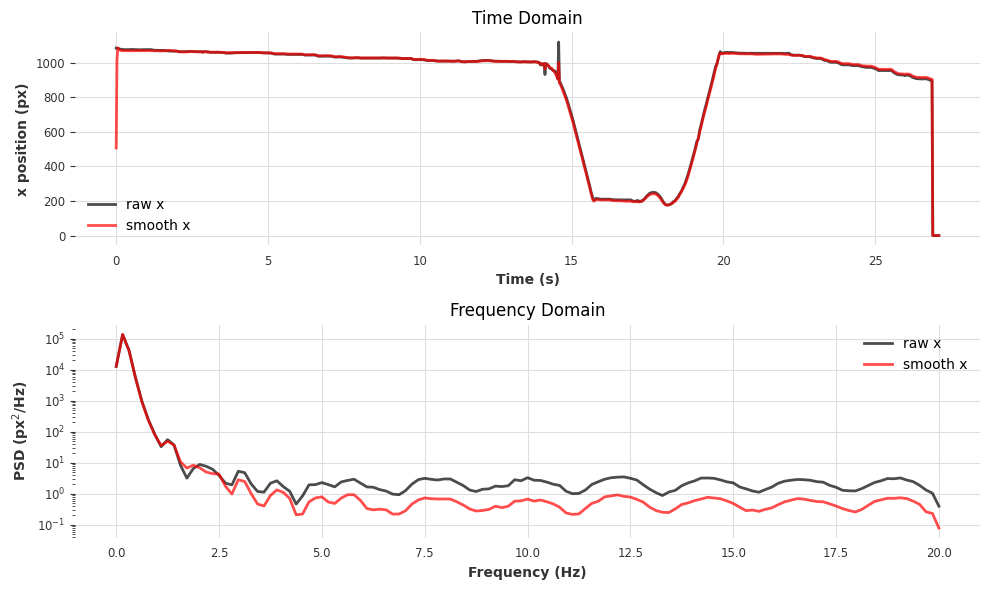

In [17]:
plot_raw_and_smooth_timeseries_and_psd(
    ds_wasp, ds_wasp_kalman, keypoint="stinger"
)